In [1]:
import scanpy as sc

# Try to use GPU-accelerated rapids_singlecell, fall back to scanpy
try:
    import rapids_singlecell as rsc
    import cupy as cp
    import rmm
    from rmm.allocators.cupy import rmm_cupy_allocator
    USE_GPU = True
    print("Using GPU-accelerated rapids_singlecell")
except ImportError:
    rsc = sc
    USE_GPU = False
    print("rapids_singlecell not available, using scanpy (CPU)")

import numpy as np
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

import os
import yaml

/home/ncostigan/.local/share/mamba/envs/prisma/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU-accelerated rapids_singlecell


In [2]:
if USE_GPU:
    rmm.reinitialize(
        managed_memory=False,
        pool_allocator=True,
        devices=0,
    )
    cp.cuda.set_allocator(rmm_cupy_allocator)

In [3]:
CONFIG_PATH = "config/annotate.yaml"

with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

INPUT_FILE = config['input_file']
OUTPUT_DIR = config['output_dir']
OUTPUT_PREFIX = config['output_prefix']

# e.g., "cell_type_markers" -> annotation name "cell_type"
PANELS = {}
for panel_key, panel_path in config['panels'].items():
    annotation_name = panel_key.replace('_markers', '')
    PANELS[annotation_name] = panel_path

MIN_SCORE = config.get('min_score', None)

print(f"Loaded config from {CONFIG_PATH}")
print(f"Input: {INPUT_FILE}")
print(f"Output prefix: {OUTPUT_PREFIX}")
print(f"Min score threshold: {MIN_SCORE}")
print(f"Panels: {list(PANELS.keys())}")

Loaded config from config/annotate.yaml
Input: tma_processed.h5ad
Output prefix: tma
Min score threshold: 0.1
Panels: ['cell_type', 'cell_state', 'gbm_subtype']


In [4]:
sc.settings.figdir = os.path.join(OUTPUT_DIR, 'plots/annotate')
os.makedirs(sc.settings.figdir, exist_ok=True)

In [5]:
adata = sc.read_h5ad(INPUT_FILE)
print(f"Loaded: {adata.shape[0]} cells x {adata.shape[1]} genes")
print(f"Clusters: {adata.obs['leiden'].nunique()} unique values")
print(f"\nCluster sizes:")
print(adata.obs['leiden'].value_counts())

Loaded: 383738 cells x 443 genes
Clusters: 16 unique values

Cluster sizes:
leiden
14    48745
7     37478
5     36755
9     35755
6     28938
12    26303
11    25325
8     24151
2     23139
13    22323
15    19662
1     15820
0     13426
4     11047
10     9986
3      4885
Name: count, dtype: int64


In [6]:
available_genes = set(adata.var_names)

def parse_panel(panel_path, annotation_name, available_genes):
    """Parse panel CSV into category -> gene list dictionary."""
    panel_df = pd.read_csv(panel_path)
    
    # Find the category column (should match annotation_name or be second column)
    if annotation_name in panel_df.columns:
        category_col = annotation_name
    else:
        # Use second column (first is 'gene')
        category_col = panel_df.columns[1]
    
    category_to_genes = defaultdict(list)
    for _, row in panel_df.iterrows():
        gene = row['gene']
        category = row[category_col]
        if gene in available_genes:
            category_to_genes[category].append(gene)
    
    return dict(category_to_genes)

panel_data = {}  # annotation_name -> {category -> [genes]}
for annotation_name, panel_path in PANELS.items():
    panel_data[annotation_name] = parse_panel(panel_path, annotation_name, available_genes)
    n_categories = len(panel_data[annotation_name])
    n_genes = sum(len(genes) for genes in panel_data[annotation_name].values())
    print(f"{annotation_name}: {n_categories} categories, {n_genes} genes in data")
    print(f"  Categories: {list(panel_data[annotation_name].keys())}")

cell_type: 14 categories, 73 genes in data
  Categories: ['Excitatory Neurons', 'OPCs', 'Oligodendrocytes', 'Astrocytes', 'Vascular Cells', 'Neural Stem Cells', 'Microglia', 'CD8+ T Cells', 'CD4+ T Cells', 'Regulatory T Cells ', 'Exhausted T Cells ', 'Tumor-Associated Macrophages', 'Glioblastoma (Cancer cells)', 'Glioblastoma (TME)']
cell_state: 4 categories, 18 genes in data
  Categories: ['Proliferation', 'Migration', 'Angiogenesis', 'Hypoxia']
gbm_subtype: 7 categories, 34 genes in data
  Categories: ['AC', 'G2/M', 'MES1', 'MES2', 'NPC1', 'NPC2', 'OPC']


In [7]:
def run_score_genes(adata, gene_list, score_name,  use_gpu=True):
    """
    Run score_genes using either rapids_singlecell (GPU) or scanpy (CPU).
    """
    valid_genes = [g for g in gene_list if g in adata.var_names]
    
    if len(valid_genes) == 0:
        print(f"  Warning: No valid genes for {score_name}")
        adata.obs[score_name] = 0.0
        return
    
    if use_gpu and USE_GPU:
        rsc.tl.score_genes(adata, valid_genes, score_name=score_name)
    else:
        sc.tl.score_genes(adata, valid_genes, score_name=score_name)

In [8]:
# score_genes expects log-normalized data, use counts layer if available
adata_score = adata.copy()

if USE_GPU:
    rsc.get.anndata_to_GPU(adata_score)

In [9]:
for annotation_name, category_to_genes in panel_data.items():
    print(f"Scoring {annotation_name}...")
    for category, genes in category_to_genes.items():
        score_name = f"score_{annotation_name}_{category.replace(' ', '_').replace('/', '_')}"
        run_score_genes(adata_score, genes, score_name, use_gpu=USE_GPU)
        print(f"  {category}: {len(genes)} genes")

Scoring cell_type...
  Excitatory Neurons: 1 genes
  OPCs: 2 genes
  Oligodendrocytes: 1 genes
  Astrocytes: 3 genes
  Vascular Cells: 3 genes
  Neural Stem Cells: 2 genes
  Microglia: 13 genes
  CD8+ T Cells: 6 genes
  CD4+ T Cells: 1 genes
  Regulatory T Cells : 3 genes
  Exhausted T Cells : 5 genes
  Tumor-Associated Macrophages: 7 genes
  Glioblastoma (Cancer cells): 4 genes
  Glioblastoma (TME): 22 genes
Scoring cell_state...
  Proliferation: 5 genes
  Migration: 6 genes
  Angiogenesis: 5 genes
  Hypoxia: 2 genes
Scoring gbm_subtype...
  AC: 6 genes
  G2/M: 2 genes
  MES1: 12 genes
  MES2: 2 genes
  NPC1: 5 genes
  NPC2: 3 genes
  OPC: 4 genes


In [10]:
def aggregate_cluster_scores(adata, category_to_genes, annotation_name):
    """
    Aggregate per-cell scores to per-cluster mean scores.
    Returns a DataFrame with clusters as rows and categories as columns.
    """
    clusters = sorted(adata.obs['leiden'].unique(), key=lambda x: int(x) if str(x).isdigit() else x)
    
    results = {}
    for cluster in clusters:
        mask = adata.obs['leiden'] == cluster
        results[cluster] = {}
        
        for cat in category_to_genes.keys():
            cat_safe = cat.replace(' ', '_').replace('/', '_')
            col = f"score_{annotation_name}_{cat_safe}"
            if col in adata.obs.columns:
                values = adata.obs.loc[mask, col]
                results[cluster][cat] = np.mean(values)
    
    return pd.DataFrame(results).T

In [11]:
scores_data = {}  # annotation_name -> DataFrame of scores
for annotation_name, category_to_genes in panel_data.items():
    scores_data[annotation_name] = aggregate_cluster_scores(adata_score, category_to_genes, annotation_name)
    print(f"\n{annotation_name} scores per cluster:")
    display(scores_data[annotation_name])


cell_type scores per cluster:


,Excitatory Neurons,OPCs,Oligodendrocytes,Astrocytes,Vascular Cells,Neural Stem Cells,Microglia,CD8+ T Cells,CD4+ T Cells,Regulatory T Cells,Exhausted T Cells,Tumor-Associated Macrophages,Glioblastoma (Cancer cells),Glioblastoma (TME)
0,-0.379576,-0.457539,-0.228237,-1.298510,2.130036,0.729725,-0.054170,-0.011345,-0.243735,-0.019608,0.065132,-0.038853,-0.062492,-0.142223
1,-0.403338,-0.167846,-0.267493,-0.994878,1.973340,-0.078431,0.020348,0.036476,0.319531,-0.001730,-0.003523,0.063420,-0.023105,-0.082625
2,-0.032283,-0.041377,0.010290,0.066253,-0.339831,-0.108742,0.169438,-0.029250,0.225008,0.020191,-0.042481,0.094125,-0.064806,0.133537
3,-0.006344,-0.312538,-0.087496,-0.773407,0.195030,-0.189008,0.070717,1.183247,0.447211,-0.131083,0.093292,-0.038095,-0.098975,0.680362
4,0.850507,-0.072085,0.389844,-0.228500,-0.249718,-0.233163,-0.235904,0.039278,-0.252107,-0.091590,-0.028893,-0.193744,-0.228579,-0.131316
5,-0.060824,0.226959,-0.013052,0.207089,-0.189155,0.053280,-0.214547,-0.012476,-0.295801,-0.003617,0.009836,-0.135096,-0.000271,-0.154311
6,-0.051303,-0.034517,-0.130937,0.168249,-0.235133,0.138602,-0.163694,-0.026505,-0.426392,-0.002715,-0.018074,-0.142135,0.393446,-0.173512
7,-0.013349,-0.020601,-0.037837,-0.034760,-0.010080,-0.026489,-0.037591,-0.005363,-0.085160,-0.002400,-0.011057,-0.002336,0.229742,-0.016147
8,0.317417,0.026881,0.357225,0.087483,-0.040160,-0.062754,-0.099867,0.011583,-0.069246,-0.017972,0.016479,-0.064984,-0.081980,-0.034020
9,0.039305,0.169820,-0.002348,0.543023,-0.075085,0.263220,-0.099239,-0.006388,-0.174299,-0.007164,0.016596,-0.090970,0.168587,-0.087068



cell_state scores per cluster:


,Proliferation,Migration,Angiogenesis,Hypoxia
0,0.044623,-0.112762,0.533453,0.141384
1,-0.183558,-0.007250,0.032516,0.029688
2,-0.136153,0.015039,-0.122583,-0.135374
3,0.029513,-0.149418,-0.182468,0.528129
4,-0.060699,-0.038263,-0.052020,-0.141464
5,0.970169,-0.117368,-0.037143,-0.030570
6,-0.211836,-0.000418,0.072654,0.010480
7,-0.073123,0.020259,0.120675,0.055459
8,0.010240,-0.018018,-0.000033,-0.034947
9,-0.074649,-0.012826,0.061448,-0.014165



gbm_subtype scores per cluster:


,AC,G2/M,MES1,MES2,NPC1,NPC2,OPC
0,-0.559964,-0.242250,0.180981,0.849435,-0.405133,-0.163185,-0.616918
1,-0.483695,-0.153891,0.469263,0.121099,-0.374000,-0.190909,-0.478844
2,0.006248,-0.257486,0.045821,-0.075979,-0.015004,-0.030206,0.006672
3,-0.650052,0.040254,-0.120585,-0.092021,-0.342593,-0.258126,-0.557652
4,-0.232067,-0.031780,-0.247495,-0.015861,0.253914,0.330111,-0.115049
5,0.024166,1.323278,-0.179727,-0.019126,0.330096,0.418467,0.110062
6,0.089734,-0.262088,0.437796,0.032023,-0.279354,-0.267201,-0.048537
7,-0.059092,-0.070312,0.128891,0.215214,-0.177303,-0.131061,-0.167248
8,0.069224,0.018171,-0.161816,-0.010595,0.302758,0.366999,0.072544
9,0.521832,-0.089048,0.065565,-0.080077,0.069455,-0.064477,0.400658


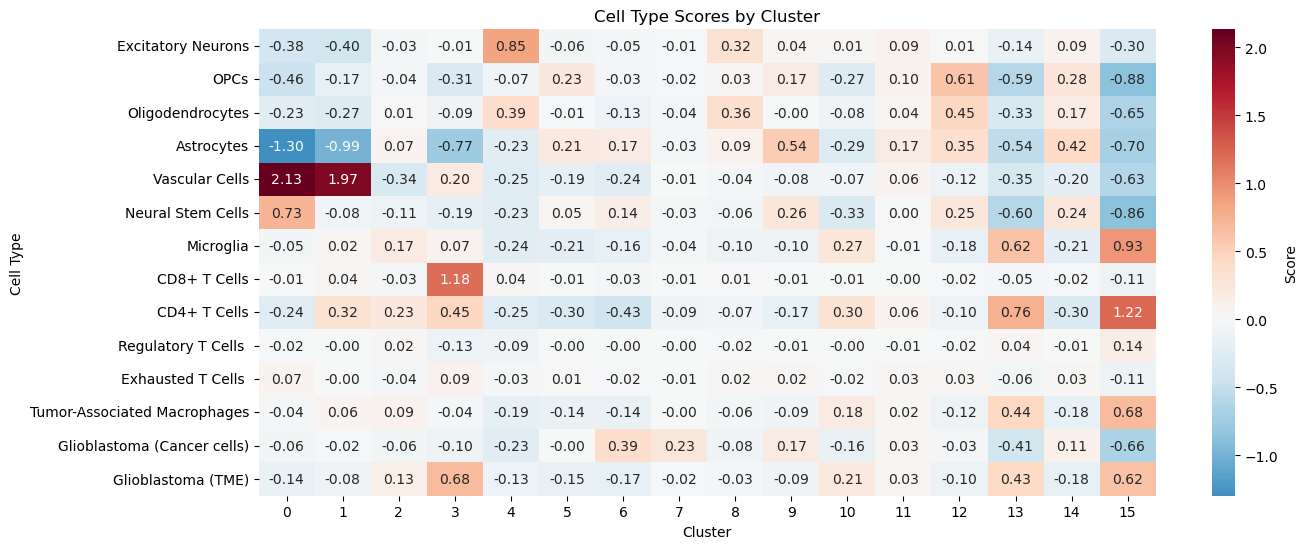

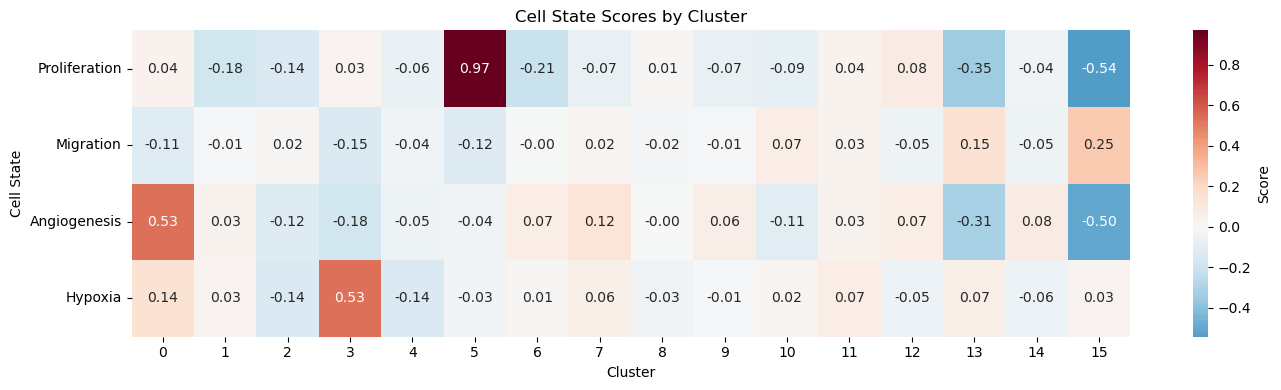

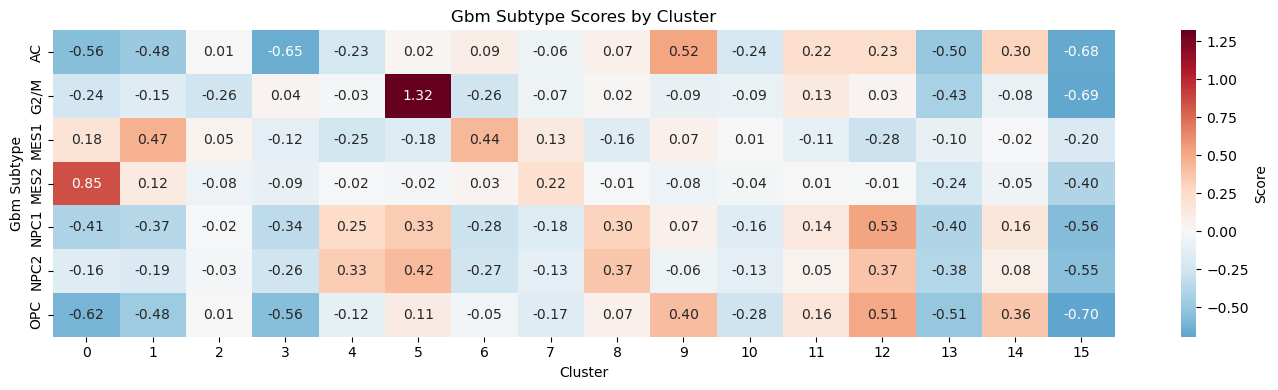

In [12]:
for annotation_name, scores_df in scores_data.items():
    n_categories = len(scores_df.columns)
    fig_height = max(4, n_categories * 0.4)
    
    fig, ax = plt.subplots(figsize=(14, fig_height))
    sns.heatmap(scores_df.T, cmap='RdBu_r', center=0, ax=ax,
                annot=True, fmt='.2f', cbar_kws={'label': 'Score'})
    ax.set_xlabel('Cluster')
    ax.set_ylabel(annotation_name.replace('_', ' ').title())
    ax.set_title(f'{annotation_name.replace("_", " ").title()} Scores by Cluster')
    plt.tight_layout()
    plt.savefig(f'{sc.settings.figdir}/{OUTPUT_PREFIX}_{annotation_name}_scores.png', dpi=150, bbox_inches='tight')
    plt.show()

In [13]:
def assign_annotation(scores_df, min_score=None, default='Unclassified'):
    """
    Assign annotation to each cluster based on highest score.
    Returns dict with cluster -> {primary, score, second, second_score, third, third_score}
    If min_score is set and highest score is below it, primary will be 'Unclassified'.
    """
    assignments = {}
    
    for cluster in scores_df.index:
        row = scores_df.loc[cluster]
        sorted_scores = row.sort_values(ascending=False)
        
        primary = sorted_scores.index[0]
        primary_score = sorted_scores.iloc[0]
        
        # Apply minimum score threshold
        if min_score is not None and primary_score < min_score:
            primary = default
        
        second = sorted_scores.index[1] if len(sorted_scores) > 1 else default
        second_score = sorted_scores.iloc[1] if len(sorted_scores) > 1 else 0
        
        third = sorted_scores.index[2] if len(sorted_scores) > 2 else default
        third_score = sorted_scores.iloc[2] if len(sorted_scores) > 2 else 0
        
        assignments[cluster] = {
            'primary': primary,
            'score': primary_score,
            'second': second,
            'second_score': second_score,
            'third': third,
            'third_score': third_score
        }
    
    return assignments

In [14]:
assignments_data = {}
for annotation_name, scores_df in scores_data.items():
    assignments_data[annotation_name] = assign_annotation(scores_df, min_score=MIN_SCORE)


def get_top_genes_for_category(adata, cluster, genes, n_top=3):
    """Get top expressing genes from a specific gene list for a cluster."""
    valid_genes = [g for g in genes if g in adata.var_names]
    if not valid_genes:
        return ""
    
    mask = adata.obs['leiden'] == cluster
    cluster_data = adata[mask, valid_genes]
    
    if hasattr(cluster_data.X, 'toarray'):
        mean_expr = np.array(cluster_data.X.toarray().mean(axis=0)).flatten()
    else:
        mean_expr = np.array(cluster_data.X.mean(axis=0)).flatten()
    
    top_indices = np.argsort(mean_expr)[::-1][:n_top]
    top_genes = [valid_genes[i] for i in top_indices]
    return ", ".join(top_genes)


summary_data = []
clusters = sorted(scores_data[list(scores_data.keys())[0]].index, key=lambda x: int(x) if str(x).isdigit() else x)

for cluster in clusters:
    n_cells = (adata.obs['leiden'] == cluster).sum()
    row = {'Cluster': cluster, 'N_Cells': n_cells}
    
    for annotation_name in assignments_data.keys():
        a = assignments_data[annotation_name][cluster]
        category_to_genes = panel_data[annotation_name]
        
        row[annotation_name] = a['primary']
        row[f'{annotation_name}_score'] = f"{a['score']:.3f}"
        if a['primary'] in category_to_genes:
            row[f'{annotation_name}_genes'] = get_top_genes_for_category(adata, cluster, category_to_genes[a['primary']])
        else:
            row[f'{annotation_name}_genes'] = ""
        
        row[f'{annotation_name}_2nd'] = a['second']
        row[f'{annotation_name}_2nd_score'] = f"{a['second_score']:.3f}"
        if a['second'] in category_to_genes:
            row[f'{annotation_name}_2nd_genes'] = get_top_genes_for_category(adata, cluster, category_to_genes[a['second']])
        else:
            row[f'{annotation_name}_2nd_genes'] = ""
        
        row[f'{annotation_name}_3rd'] = a['third']
        row[f'{annotation_name}_3rd_score'] = f"{a['third_score']:.3f}"
        if a['third'] in category_to_genes:
            row[f'{annotation_name}_3rd_genes'] = get_top_genes_for_category(adata, cluster, category_to_genes[a['third']])
        else:
            row[f'{annotation_name}_3rd_genes'] = ""
    
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print("Cluster Annotations Summary:")
display(summary_df)

Cluster Annotations Summary:


,Cluster,N_Cells,cell_type,cell_type_score,cell_type_genes,cell_type_2nd,cell_type_2nd_score,cell_type_2nd_genes,cell_type_3rd,cell_type_3rd_score,...,cell_state_3rd_genes,gbm_subtype,gbm_subtype_score,gbm_subtype_genes,gbm_subtype_2nd,gbm_subtype_2nd_score,gbm_subtype_2nd_genes,gbm_subtype_3rd,gbm_subtype_3rd_score,gbm_subtype_3rd_genes
0,0,13426,Vascular Cells,2.130,"FLT1, RGS5, DCN",Neural Stem Cells,0.730,"ID1, NOTCH1",Exhausted T Cells,0.065,...,"KIT, CDK1, MKI67",MES2,0.849,"IGFBP3, CDKN1A",MES1,0.181,"FN1, A2M, IGFBP7",NPC2,-0.163,"SOX4, STMN1, SOX11"
1,1,15820,Vascular Cells,1.973,"DCN, RGS5, FLT1",CD4+ T Cells,0.320,CD4,Tumor-Associated Macrophages,0.063,...,"MMP9, MMP12, CTSS",MES1,0.469,"FN1, MGP, IGFBP7",MES2,0.121,"IGFBP3, CDKN1A",G2/M,-0.154,"PLK1, CENPF"
2,2,23139,CD4+ T Cells,0.225,CD4,Microglia,0.169,"AIF1, APOE, TREM2",Glioblastoma (TME),0.134,...,"HIF1A, CXCR4",Unclassified,0.046,,OPC,0.007,"TTYH1, BCAN, VCAN",AC,0.006,"S100B, SLC1A3, TTYH1"
3,3,4885,CD8+ T Cells,1.183,"GZMA, GZMK, CD8A",Glioblastoma (TME),0.680,"CD2, IL7R, GZMA",CD4+ T Cells,0.447,...,"CTSS, MMP12, MMP9",Unclassified,0.040,,MES2,-0.092,"IGFBP3, CDKN1A",MES1,-0.121,"MGP, IFITM3, FN1"
4,4,11047,Excitatory Neurons,0.851,NELL2,Oligodendrocytes,0.390,ERBB3,CD8+ T Cells,0.039,...,"KIT, CDK6, CENPF",NPC2,0.330,"STMN1, SOX4, SOX11",NPC1,0.254,"STMN1, DLL3, SOX4",MES2,-0.016,"CDKN1A, IGFBP3"
5,5,36755,OPCs,0.227,"VCAN, PDGFRA",Astrocytes,0.207,"SOX9, S100B, SLC1A3",Neural Stem Cells,0.053,...,"VEGFA, FGF2, CXCL2",G2/M,1.323,"CENPF, PLK1",NPC2,0.418,"STMN1, SOX11, SOX4",NPC1,0.330,"STMN1, SOX11, BCAN"
6,6,28938,Glioblastoma (Cancer cells),0.393,"CD44, ANXA1, CAV1",Astrocytes,0.168,"SOX9, SLC1A3, S100B",Neural Stem Cells,0.139,...,"CTSD, CTSB, CTSL",MES1,0.438,"C1S, C1R, CD44",AC,0.090,"SPARCL1, SLC1A3, TTYH1",MES2,0.032,"CDKN1A, IGFBP3"
7,7,37478,Glioblastoma (Cancer cells),0.230,"CD44, CAV1, ANXA1",Tumor-Associated Macrophages,-0.002,"ARG1, CCR2, IL10",Regulatory T Cells,-0.002,...,"MMP12, MMP9, CTSL",MES2,0.215,"IGFBP3, CDKN1A",MES1,0.129,"CD44, SPP1, C1R",AC,-0.059,"SPARCL1, SPARC, SLC1A3"
8,8,24151,Oligodendrocytes,0.357,ERBB3,Excitatory Neurons,0.317,NELL2,Astrocytes,0.087,...,"MMP12, MMP9, CTSL",NPC2,0.367,"STMN1, SOX4, SOX11",NPC1,0.303,"STMN1, DLL3, SOX4",OPC,0.073,"BCAN, GPR17, TTYH1"
9,9,35755,Astrocytes,0.543,"SLC1A3, S100B, SOX9",Neural Stem Cells,0.263,"NOTCH1, ID1",OPCs,0.170,...,"HIF1A, CXCR4",AC,0.522,"TTYH1, SLC1A3, BCAN",OPC,0.401,"TTYH1, BCAN, VCAN",NPC1,0.069,"BCAN, SOX4, SOX11"


In [15]:
leiden_str = adata.obs['leiden'].astype(str)

for annotation_name, assignments in assignments_data.items():
    cluster_to_annotation = {str(c): assignments[c]['primary'] for c in assignments}
    adata.obs[annotation_name] = leiden_str.map(cluster_to_annotation).astype('category')
    print(f"Added {annotation_name} annotation")

score_cols = [c for c in adata_score.obs.columns if c.startswith('score_')]
for col in score_cols:
    adata.obs[col] = adata_score.obs[col]

print(f"Added {len(score_cols)} score columns")

Added cell_type annotation
Added cell_state annotation
Added gbm_subtype annotation
Added 25 score columns


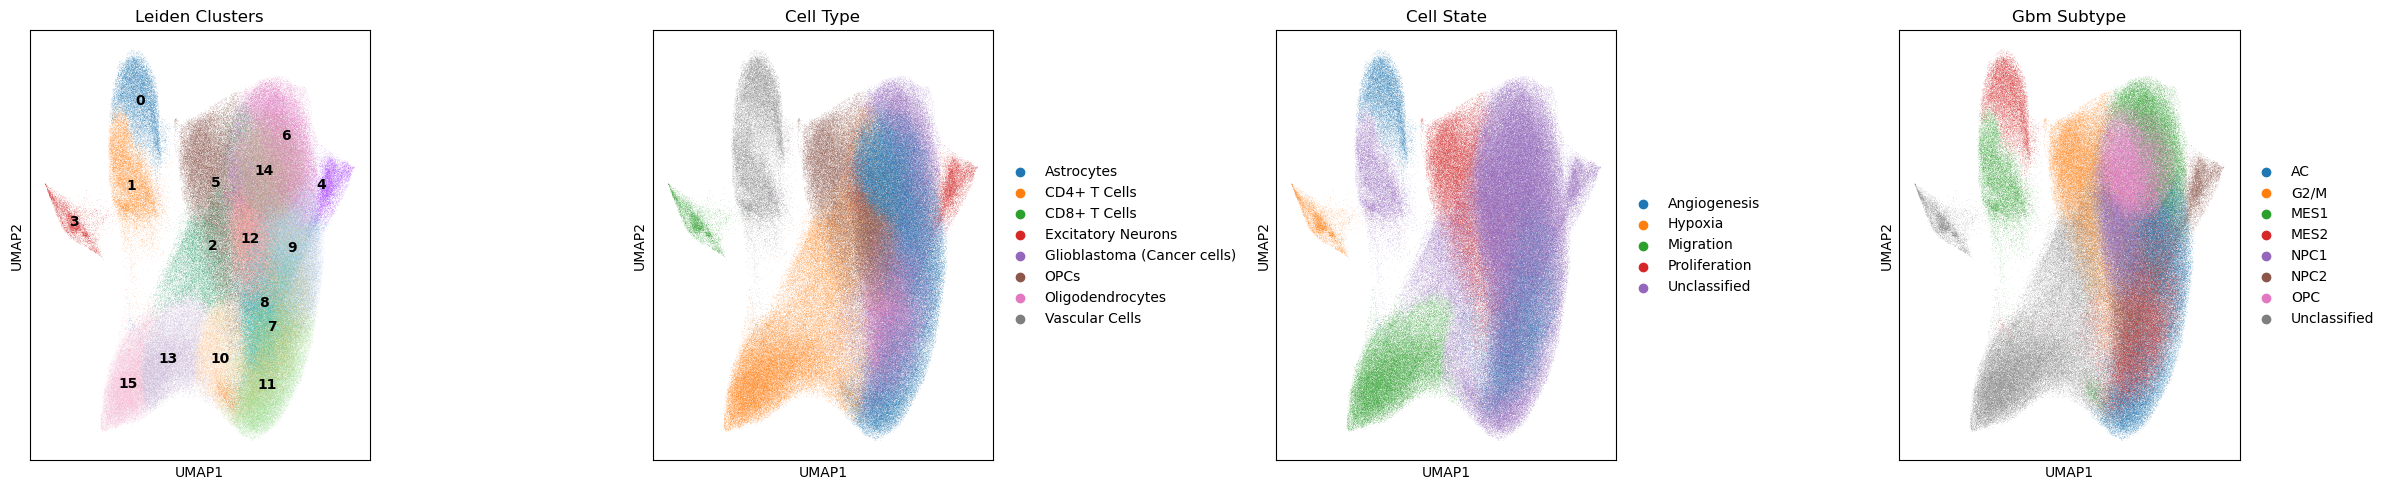

In [16]:
n_plots = 1 + len(assignments_data)
fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 5))

sc.pl.umap(adata, color='leiden', ax=axes[0], show=False, title='Leiden Clusters', legend_loc='on data')

for idx, annotation_name in enumerate(assignments_data.keys(), start=1):
    sc.pl.umap(adata, color=annotation_name, ax=axes[idx], show=False, 
               title=annotation_name.replace('_', ' ').title())

plt.tight_layout()
plt.savefig(f'{sc.settings.figdir}/{OUTPUT_PREFIX}_umap_annotations.png', dpi=150, bbox_inches='tight')
plt.show()

Using spatial_original coordinates (multiple samples detected)


/tmp/ipykernel_1154072/3582143351.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_cats)


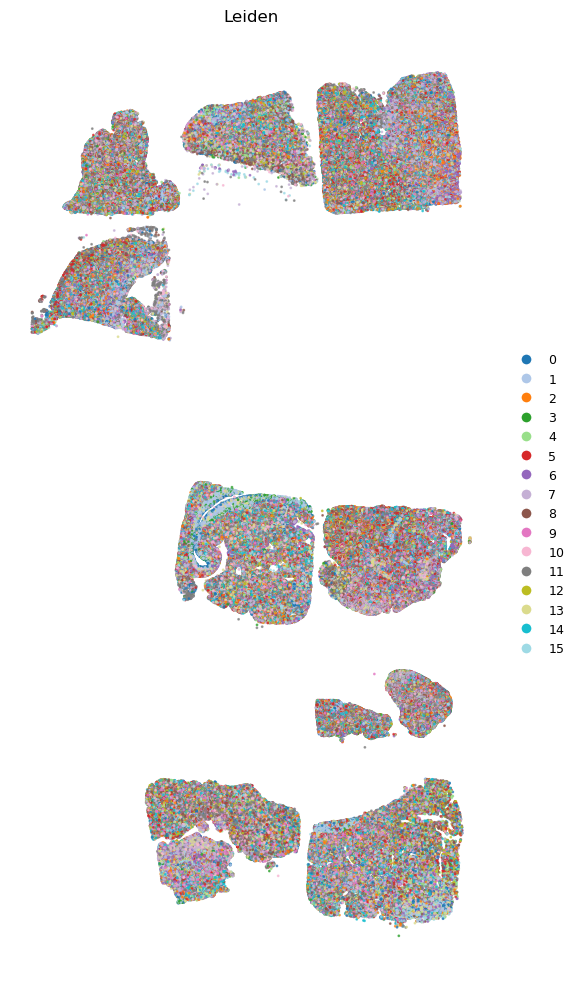

/tmp/ipykernel_1154072/3582143351.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_cats)


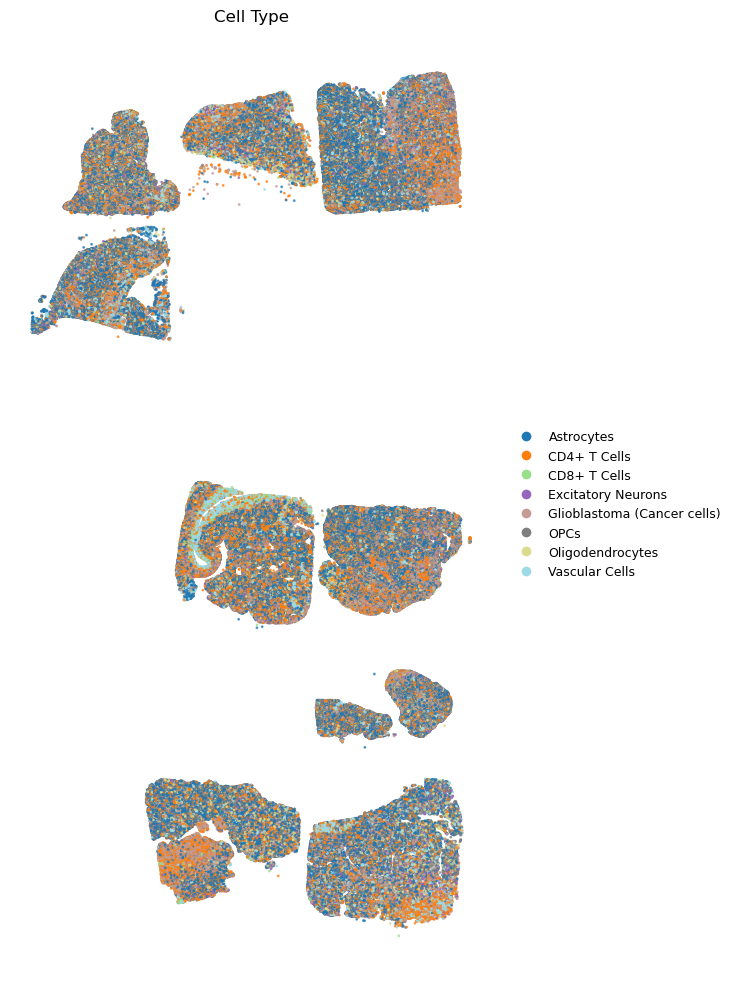

/tmp/ipykernel_1154072/3582143351.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_cats)


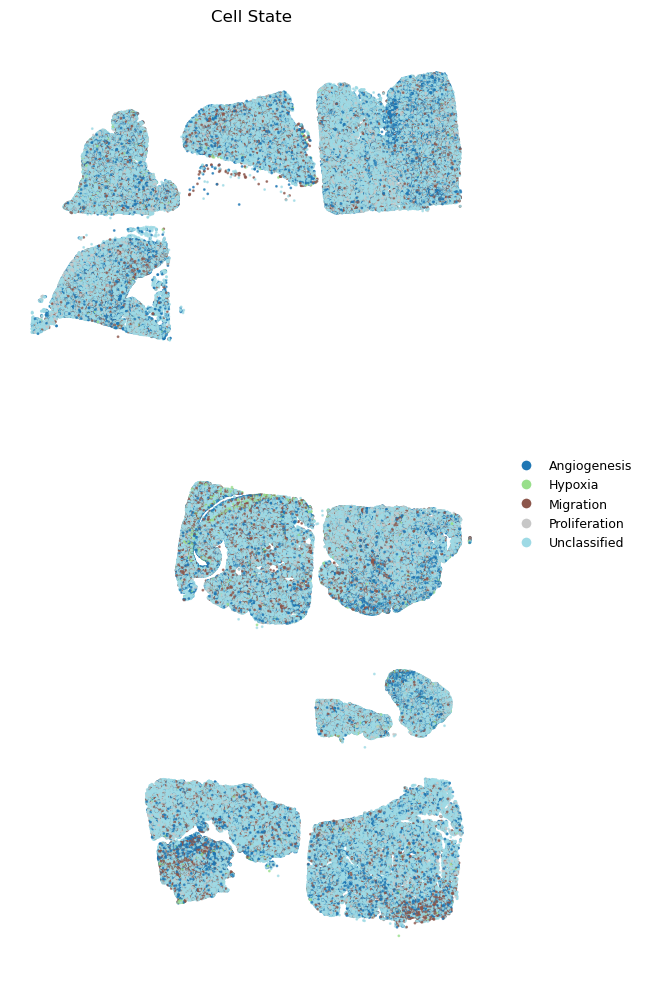

/tmp/ipykernel_1154072/3582143351.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', n_cats)


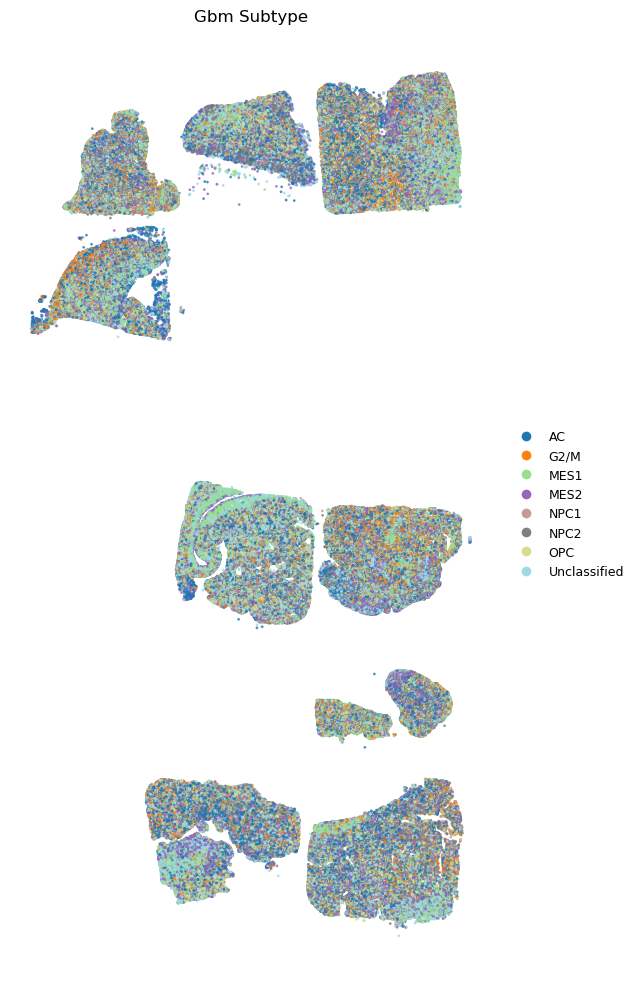

In [17]:
# Use spatial_original when available and multiple samples are present,
# since per-sample coordinates are reset to (0,0) and would overlap
if 'spatial' in adata.obsm:
    use_original = 'spatial_original' in adata.obsm and adata.obs['sample'].nunique() > 1
    coords = adata.obsm['spatial_original'] if use_original else adata.obsm['spatial']
    
    if use_original:
        print("Using spatial_original coordinates (multiple samples detected)")
    
    plot_cols = ['leiden'] + list(assignments_data.keys())
    
    for color in plot_cols:
        title = color.replace('_', ' ').title()
        categories = adata.obs[color].astype('category')
        cat_codes = categories.cat.codes
        cat_names = categories.cat.categories.tolist()
        n_cats = len(cat_names)
        
        cmap = plt.cm.get_cmap('tab20', n_cats)
        colors = [cmap(i) for i in range(n_cats)]
        
        fig, ax = plt.subplots(figsize=(12, 10))
        scatter = ax.scatter(coords[:, 0], coords[:, 1], 
                            c=cat_codes, cmap='tab20', 
                            s=1, alpha=0.7, vmin=0, vmax=n_cats-1)
        ax.set_title(title)
        ax.set_aspect('equal')
        ax.axis('off')
        
        handles = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=colors[i], markersize=8, label=cat_names[i])
                   for i in range(n_cats)]
        ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1.02, 0.5), 
                  frameon=False, fontsize=9)
        
        plt.tight_layout()
        plt.savefig(f'{sc.settings.figdir}/{OUTPUT_PREFIX}_spatial_{color}.png', dpi=150, bbox_inches='tight')
        plt.show()
else:
    print("No spatial coordinates found in adata.obsm['spatial']")

In [18]:
for annotation_name in assignments_data.keys():
    print(f"\n{annotation_name.upper().replace('_', ' ')} DISTRIBUTION")
    print("=" * 40)
    print(adata.obs[annotation_name].value_counts())


CELL TYPE DISTRIBUTION
cell_type
Astrocytes                     109825
CD4+ T Cells                    75110
Glioblastoma (Cancer cells)     66416
OPCs                            63058
Vascular Cells                  29246
Oligodendrocytes                24151
Excitatory Neurons              11047
CD8+ T Cells                     4885
Name: count, dtype: int64

CELL STATE DISTRIBUTION
cell_state
Unclassified     249209
Angiogenesis      50904
Migration         41985
Proliferation     36755
Hypoxia            4885
Name: count, dtype: int64

GBM SUBTYPE DISTRIBUTION
gbm_subtype
Unclassified    79995
AC              61080
MES2            50904
OPC             48745
MES1            44758
G2/M            36755
NPC2            35198
NPC1            26303
Name: count, dtype: int64


In [19]:
output_path = os.path.join(OUTPUT_DIR, f'{OUTPUT_PREFIX}_annotated.h5ad')
adata.write_h5ad(output_path)
print(f"Saved annotated data to: {output_path}")

summary_path = os.path.join(sc.settings.figdir, f'{OUTPUT_PREFIX}_annotations.csv')
summary_df.to_csv(summary_path, index=False)
print(f"Saved annotation summary to: {summary_path}")

for annotation_name, scores_df in scores_data.items():
    scores_path = os.path.join(sc.settings.figdir, f'{OUTPUT_PREFIX}_{annotation_name}_scores.csv')
    scores_df.to_csv(scores_path)
    print(f"Saved {annotation_name} scores to: {scores_path}")

Saved annotated data to: ./tma_annotated.h5ad
Saved annotation summary to: plots/annotate/tma_annotations.csv
Saved cell_type scores to: plots/annotate/tma_cell_type_scores.csv
Saved cell_state scores to: plots/annotate/tma_cell_state_scores.csv
Saved gbm_subtype scores to: plots/annotate/tma_gbm_subtype_scores.csv
